## MIS780 - Advanced Artificial Intelligence for Business

## Week 8 - Part 2:  Genetic Algorithm in Machine Learning

In this session, you will learn how to perform feature selection in machine learning using Genetic Algorithm.

## Table of Content
   

1. [Dataset](#cell_Dataset)


2. [Genetic Algorithm Construction](#cell_Build)


3. [Feature Selection](#cell_Feature)



<a id = "cell_Dataset"></a>
### 1.  Dataset

Firstly, we import all required libraries.

In [1]:
!pip install scikit-learn==1.1.3

import random
import numpy as np
import matplotlib.pyplot as plt

We will use simple dataset, the **Boston Housing** dataset, in a classic regression task of predicting house prices. There are 13 numeric and categorical variables constituting a price of a house in the Boston area. The data set can be loaded from `sklearn` library.

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

SEED = 2018
random.seed(SEED)
np.random.seed(SEED)

dataset = load_boston()
X, y = dataset.data, dataset.target
features = dataset.feature_names
print(X)
print(y)
print(features)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Let’s calculate CV score of Linear Regression estimator. We select mean squared error (MSE) as a metric:

In [3]:
est = LinearRegression()
score = -1.0 * cross_val_score(est, X, y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

CV MSE before feature selection: 37.13


The CV MSE is around 37. It is calculated assuming that all features are taken into account. This error can be reduced with proper feature selection algorithm i.e. selecting variables that are most important to the model and skipping redundant ones.

We can do feature selection be trying all possible combination of the 13 features (*_the expensive way_*) or we can use genetic algorithm to perform feature selection (*_the quick way_*) with very good results.

<a id = "cell_Build"></a>
###  2. Genetic Algorithm Construction

Genetic algorithm consists of different operations and parameters, thus it is beneficial to enclose it as a Python class. We will initialize  `GeneticSelector`  with several parameters describing genetic algorithm.

In [4]:
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand,
                 n_children, mutation_rate):
        # Estimator
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select (Elitism)
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate

        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")

**Genes**: There are 13 features in the Boston Housing dataset. Using genetic algorithm nomenclature a feature is called a gene. It can be either included (1) or excluded (0) during feature selection process.

**Chromosome**: A list of 13 genes is called a chromosome. The chromosome contains information which feature is included and which is excluded.

**Population**: Population contains several instances of different chromosomes. It is just a collection of different feature subsets.

The first population of `n_size`  chromosomes is created by random exclusion of features. We add a method  `initilize`  to our class.

In [5]:
def initilize(self):
    population = []
    #For each chromosome/individual, randomly select some features.
    for i in range(self.size):
        chromosome = np.ones(self.n_features, dtype=np.bool)
        mask = np.random.rand(len(chromosome)) < 0.3
        chromosome[mask] = False
        population.append(chromosome)

    return population

#Assign the initilize function to the class GeneticSelector
GeneticSelector.initilize = initilize

The probability 0.3 is chosen arbitrarily, however it is suggested to avoid large probabilities. We would not like to create chromosomes with all variables excluded.

**Fitness**: Our goal is to select such a subset of features that minimizes the CV MSE. The function that calculates fitness score for each chromosome in a population is presented below:

In [6]:
def fitness(self, population):
    X, y = self.dataset
    scores = []
    for chromosome in population:
        #Score is the MSE
        score = -1.0 * np.mean(cross_val_score(self.estimator,
                                               X[:,chromosome],
                                               y,
                                               cv=5,
                                               scoring="neg_mean_squared_error"))
        scores.append(score)

    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)

    #Return a list of fitness values and chromosomes
    return list(scores[inds]), list(population[inds,:])

GeneticSelector.fitness = fitness

The fitness function returns a list of sorted scores and a list of chromosomes sorted based on scores. These two lists will be used in the selection process.

**Selection**: We select  `n_best`  chromosomes according to CV scores, so that our population is moving towards the best solution and randomly select  `n_rand`  chromosomes, so that our optimization algorithm would not be stuck in a local optimum.

In [7]:
def select(self, population_sorted):
    population_next = []

    for i in range(self.n_best):
        population_next.append(population_sorted[i])

    for i in range(self.n_rand):
        population_next.append(random.choice(population_sorted))

    random.shuffle(population_next)

    return population_next

GeneticSelector.select = select

**Crossover**: We mix DNA of two individuals. This operation is called crossover and creates  `n_children`  for each pair of chromosomes.

We add  `crossover`  method to our class, which mixes the genes of the previously selected   `n_best+n_rand`  parents.

In [8]:
def crossover(self, population):
    population_next = []

    for i in range(int(len(population)/2)):
         for j in range(self.n_children):
            chromosome1, chromosome2 = population[i], population[len(population)-1-i]
            child = chromosome1
            mask = np.random.rand(len(child)) > 0.5
            child[mask] = chromosome2[mask]
            population_next.append(child)

    return population_next

GeneticSelector.crossover = crossover

**Mutation**: The last operation is to mutate chromosomes. A chromosome is changed a little bit in order not to converge to a local optimum too quickly. The change involves randomly excluding a feature with small probability.

In [9]:
def mutate(self, population):
    population_next = []
    for i in range(len(population)):
        chromosome = population[i]
        if random.random() < self.mutation_rate:
            mask = np.random.rand(len(chromosome)) < 0.05
            chromosome[mask] = False
        population_next.append(chromosome)

    return population_next

GeneticSelector.mutate = mutate

Note, that firstly the chromosome to mutate is randomly selected with probability  `self.mutation_rate`  and then each gene can be changed with probability 0.05. These probabilities should not be too large so that genetic algorithm can converge.

**Generation**:  The genetic operations **selection**, **crossover** and **mutation** are repeated so that each population should become better and better in terms of the CV scores.  The method  `generate`  calls genetic operations and saves the best results of each generation.

In [10]:
def generate(self, population):
    # Selection, crossover and mutation
    scores_sorted, population_sorted = self.fitness(population)
    population = self.select(population_sorted)
    population = self.crossover(population)
    population = self.mutate(population)
    # History
    self.chromosomes_best.append(population_sorted[0])
    self.scores_best.append(scores_sorted[0])
    self.scores_avg.append(np.mean(scores_sorted))

    return population

GeneticSelector.generate = generate

**Fit**: The last step will be to pass data and perform genetic algorithm. There is also a method that returns a chromosome with the best features (the best chromosome from the last generation) and a plotting function.

In [11]:
def fit(self, X, y):

    self.chromosomes_best = []
    self.scores_best, self.scores_avg  = [], []

    self.dataset = X, y
    self.n_features = X.shape[1]

    population = self.initilize()
    for i in range(self.n_gen):
        population = self.generate(population)

    return self

@property
def support_(self):
    return self.chromosomes_best[-1]

def plot_scores(self):
    plt.plot(self.scores_best, label='Best')
    plt.plot(self.scores_avg, label='Average')
    plt.legend()
    plt.ylabel('Scores')
    plt.xlabel('Generation')
    plt.show()

GeneticSelector.fit = fit
GeneticSelector.support_ = support_
GeneticSelector.plot_scores = plot_scores

<a id = "cell_Feature"></a>
###  3. Feature Selection

We have all parts of our  `GeneticSelector`  class required to perform feature selection. Let’s apply the genetic algorithm to the Boston Housing dataset and calculate CV score after feature selection.

<ipython-input-5-6d78532da944>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chromosome = np.ones(self.n_features, dtype=np.bool)


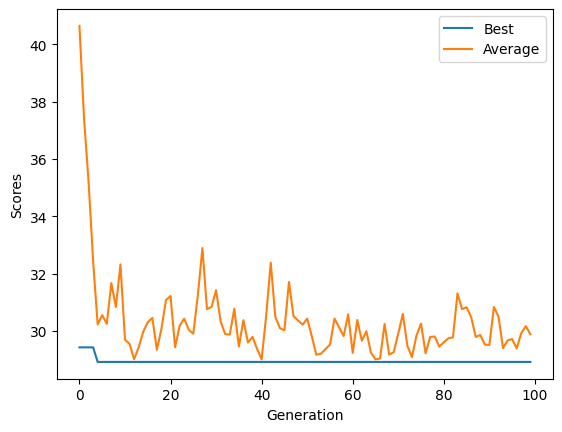

CV MSE after feature selection: 28.92


In [12]:
sel = GeneticSelector(estimator=LinearRegression(),
                      n_gen=100, size=200, n_best=40, n_rand=40,
                      n_children=5, mutation_rate=0.05)
sel.fit(X, y)
sel.plot_scores()
score = -1.0 * cross_val_score(est, X[:,sel.support_], y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))

Now, the CV MSE is around 29. It is a significant improvement (around 37 before feature selection). We can see after **4** generation the optimizer converged.

We can extract the best feature sets after running the selection algorithm

In [13]:
print('Select features are: ', features[sel.chromosomes_best[4]])
print('Score: ', round(sel.scores_best[4],3))

Select features are:  ['ZN' 'CHAS' 'NOX' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'LSTAT']
Score:  28.923


### References:

- Kopczyk, D. (n.d.). Genetic algorithm in Machine Learning. http://dkopczyk.quantee.co.uk/genetic-algorithm/